# Thorium Calibration

We simulate a thorium mantle attached next to the tank. We calculate the expected spectrum for the energy deposition as well as the rate of incidence.

In [2]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

In [3]:
# Read the files

# Parameters
run                     = 'run3'
header                  = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy']

# Find the files
foldername  = f'../build/output'
os.system(f'rm -rf ../build/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

loadFiles = parallel(loadFile)

if __name__ == '__main__':
    files = loadFiles(filenames)

Found 1024 data files in ../build/output


  0%|          | 0/1024 [00:00<?, ?it/s]

In [4]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])[['EnergyDeposited', 'Initial Energy']].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle == particle] for particle in energy.Particle.unique()}

  0%|          | 0/1024 [00:00<?, ?it/s]

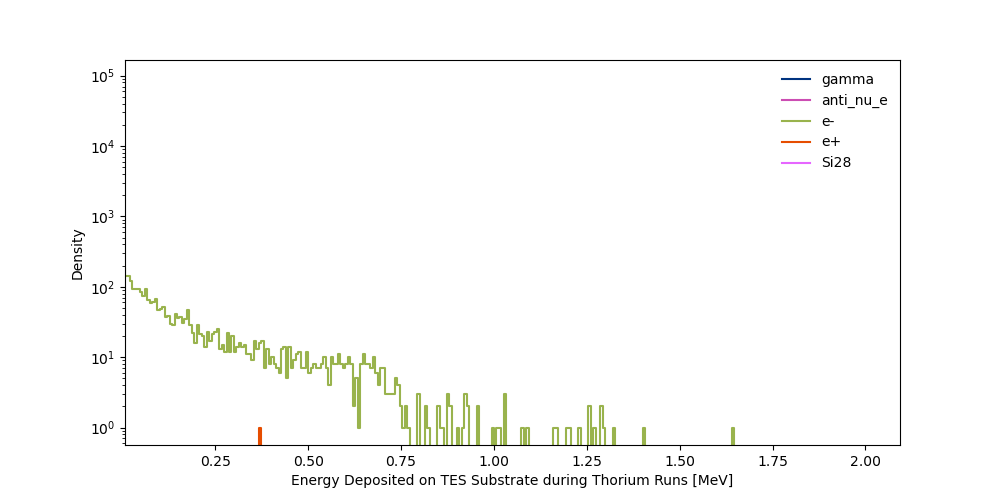

In [5]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 300
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].EnergyDeposited,bins=BINS)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

ax.set_xlim(BINS[1],None)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
ax.set_yscale('log')
# ax.set_xscale('log')

In [6]:
len(particleEnergies['gamma'].EnergyDeposited) /len(energy)

0.28241406639856753

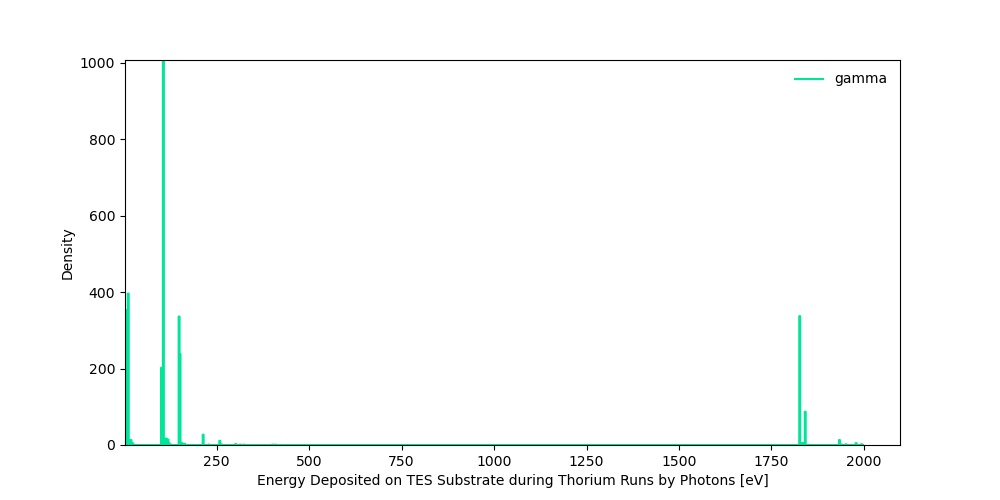

In [16]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 800
LIMS        = (0,0.002)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'gamma'
stackedHist = np.histogram(particleEnergies[PARTICLE].EnergyDeposited,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1]*1e6,stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1]*1e6,None)
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs by Photons [eV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

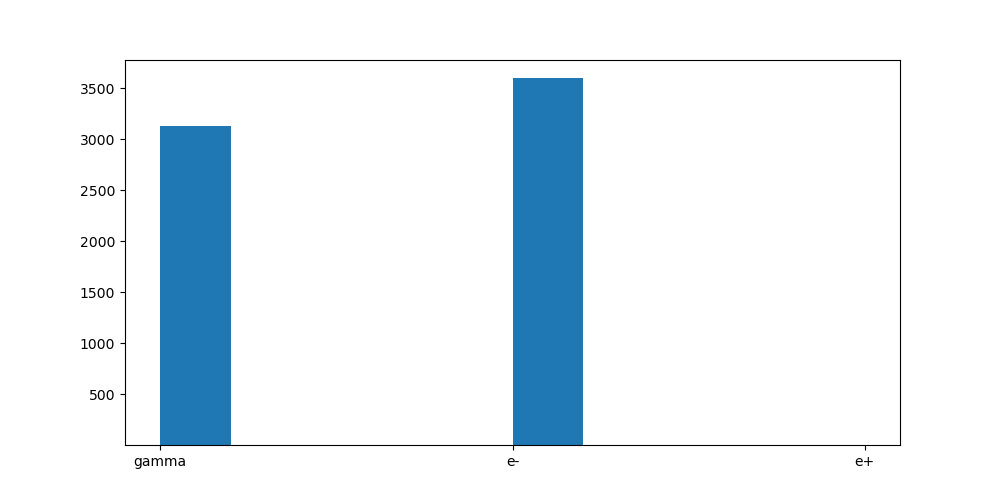

In [30]:
nonZeroEnergy = energy[energy['EnergyDeposited'] != 0]
data = nonZeroEnergy['Particle']
# data = energy['Particle']
plt.clf()
counts, bins, whatever = plt.hist(data)
# plt.yscale('log')
plt.ylim(0.1,)
plt.show()
#this is particles that have deposited energy on the tes

In [9]:
counts

array([3.8484e+04, 0.0000e+00, 9.4187e+04, 0.0000e+00, 0.0000e+00,
       3.5950e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00])

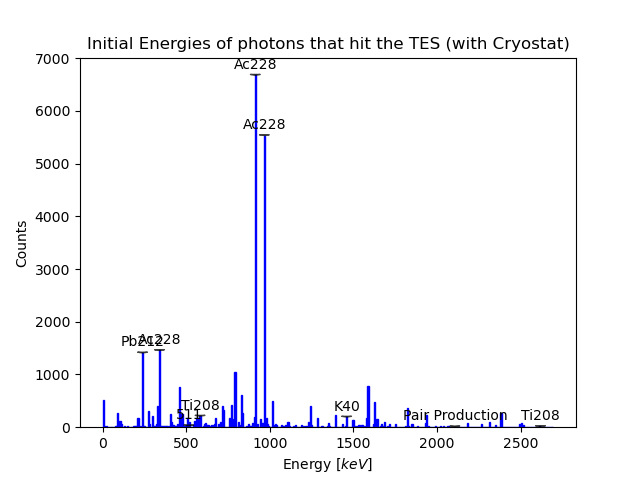

In [10]:
def annotate_peaks(ax, x_values, y_values, labels):
    for x, y, label in zip(x_values, y_values, labels):
        ax.annotate(label, xy=(x, y), xytext=(x, y + 200),  # Adjust xytext to control the label position
                    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', alpha=0.7),
                    horizontalalignment='center', verticalalignment='center')



x_irl = [238.6, 338.3, 511, 583.2, 911.2, 968.9, 1460, 2103, 2614.5]
material_names = ['Pb212', 'Ac228', '511', 'Ti208', 'Ac228', 'Ac228', 'K40', 'Pair Production', 'Ti208']
gamma = energy[energy['Particle'] == 'gamma']
gamma = gamma[gamma['Initial Energy'] < 2700]

plt.clf()
fig, ax = plt.subplots()
counts, bin_edges, patches = ax.hist(gamma['Initial Energy'], bins = 400, color = 'b', edgecolor = 'blue')
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_sim = []

for x in x_irl:
    try:
        x_sim.append(max([i for i in bin_centers if abs(x-i) < 5.]))
    except:
        pass
    
y_sim = []
for x,y in zip(bin_centers, counts):
    if x in x_sim:
        y_sim.append(y)




# plt.xscale('log')
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=100))
# ax.set_xlim(1,2700)
ax.set_xlabel('Energy [$keV$]')
ax.set_ylabel('Counts')
ax.set_yscale('linear')
ax.set_title('Initial Energies of photons that hit the TES (with Cryostat)')
annotate_peaks(ax, x_sim, y_sim, material_names)
plt.show()

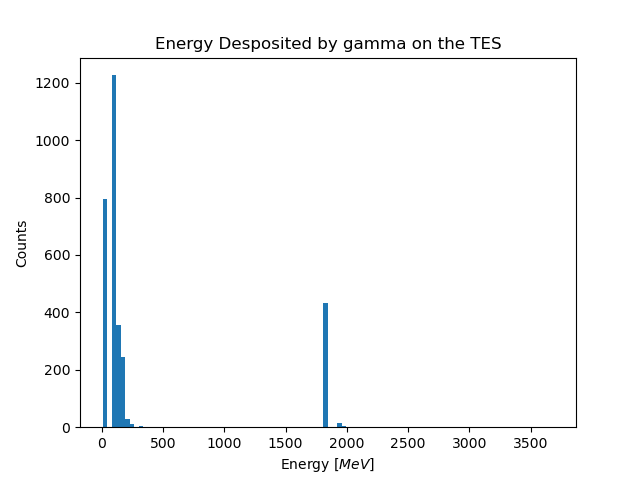

In [14]:
gamma = energy[energy['Particle'] == 'gamma']
gamma = gamma[gamma['EnergyDeposited'] > 0]
gamma = gamma['EnergyDeposited'] * 10**6
plt.clf()
plt.hist(gamma, bins = 100)
plt.title('Energy Desposited by gamma on the TES')
plt.xlabel('Energy [$MeV$]')
plt.ylabel('Counts')
# plt.xlim(0,100000)
plt.show()

In [12]:
len(gamma)

3127

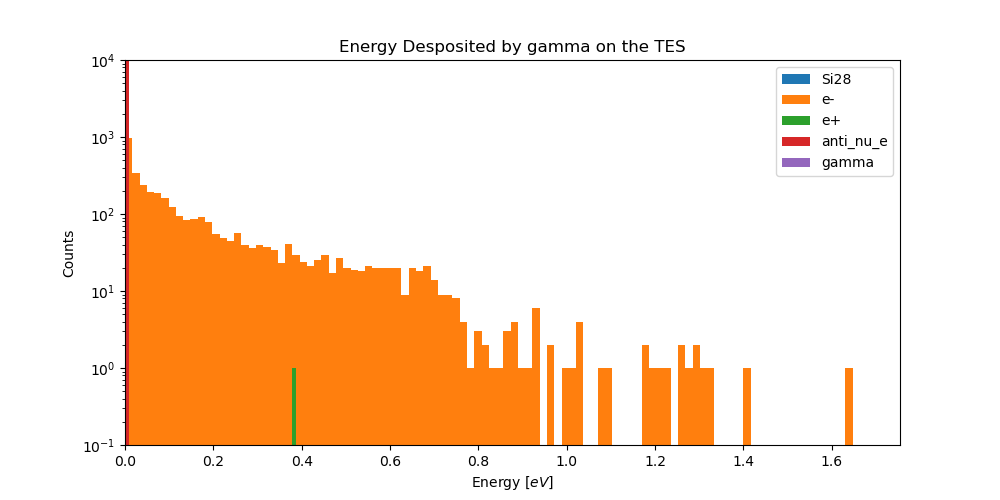

In [28]:
plt.clf()
particles = set(energy['Particle'])

for particle in particles:
    df = energy[energy['Particle'] == particle]
    # df = df[df['EnergyDeposited'] > 0]
    data = df['EnergyDeposited']
    plt.hist(data, bins = 100, label = particle)
plt.title('Energy Desposited by ' + particle + ' on the TES')
plt.xlabel('Energy [$eV$]')
plt.ylabel('Counts')
plt.xlim(0,)
plt.ylim(0.1,10000)
plt.xscale('linear')
plt.yscale('log')
plt.legend()
plt.show()

In [29]:
files[0]

,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy
0,2641,17,gamma,0,-47.5000,-370.028,-11.60070,0.912777,physSiliconSubstrate,911.209
1,5395,38,anti_nu_e,0,-47.5000,-366.651,-9.91343,0.877267,physSiliconSubstrate,165.612
2,5529,14,anti_nu_e,0,-44.9252,-371.000,-8.69687,0.896077,physSiliconSubstrate,345.994
3,10534,11,anti_nu_e,0,-43.3841,-371.000,-9.01464,0.859846,physSiliconSubstrate,529.593
4,12358,33,anti_nu_e,0,-47.5000,-367.186,-10.20080,0.898370,physSiliconSubstrate,328.211
...,...,...,...,...,...,...,...,...,...,...
157,944063,37,anti_nu_e,0,-47.5000,-370.171,-12.12510,0.891500,physSiliconSubstrate,151.810
158,953033,5,anti_nu_e,0,-44.7626,-371.000,-10.70070,0.866448,physSiliconSubstrate,35.537
159,955370,30,anti_nu_e,0,-47.5000,-366.524,-8.63604,0.862312,physSiliconSubstrate,211.151
160,956587,14,anti_nu_e,0,-47.5000,-367.732,-8.62541,0.871240,physSiliconSubstrate,296.730
